# A Multiclass Tree Approach

Previously we just looked at the two kinds of pitches, change ups and fastballs, and two different features, effective speed and spin rate. But we have both more features and more classes of pitches. Trees are flexible enough to work with any number of classes and features, just like support vector machines. So let's dig into this data in more detail.

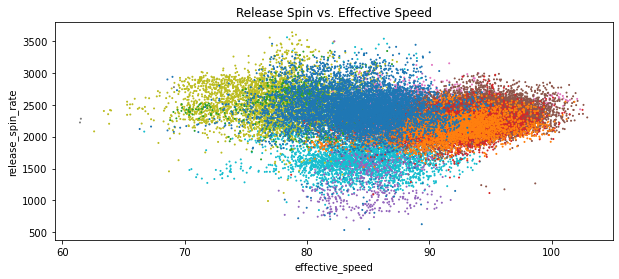

In [1]:
# Let's go back to the full pitching data
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import zipfile
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions

filename="baseball_svm_data.zip"
df=pd.read_csv(zipfile.ZipFile(filename).open("reg_Sep2019.csv"))
color_list=list(mcolors.TABLEAU_COLORS.keys())
df=df.groupby("pitch_type").apply(lambda x: x.assign(color=color_list.pop())).reset_index(drop=True)
df.plot.scatter("effective_speed", "release_spin_rate", 
                s=1, figsize=(10, 4), title="Release Spin vs. Effective Speed",
                color=df["color"], legend=True);

In [2]:
# Now, in our SVM work we looked a number of different pitch metrics and game details
# Seems like a fair approach to see how trees handle this
pitch_metrics=['release_spin_rate','release_extension','release_pos_y','release_pos_x','release_pos_z','effective_speed']
player_metrics=['player_name']
game_details=['outs_when_up','inning']
df=df[[*pitch_metrics, *player_metrics, *game_details, "pitch_type"]]

# Create a feature vector for training
features=[*pitch_metrics, *player_metrics, *game_details]

# Now let's drop where any of the pitches are nan
df=df.dropna(subset=["pitch_type"])

# And we factorize our player names and our outcomes
df['player_name']=df['player_name'].factorize()[0]
df['pitch_type2']=df['pitch_type'].factorize()[0]

# We shuffle the data in the DataFrame to eliminate any sorting
df=df.sample(frac=1, random_state=1337).reset_index(drop=True)

In [3]:
# Now, before we create the validation and the training sets lets talk about
# what we actually have in our data. Let's look at the prevelance of each class
# - each type of pitch - in our actual data.
df.groupby(["pitch_type","pitch_type2"]).apply(len)

pitch_type  pitch_type2
CH          0               4485
CU          1               4141
EP          2                  3
FC          3               2309
FF          4              14039
FS          5                575
FT          6               3203
KC          7                656
SI          8               2924
SL          9               7656
dtype: int64

In [4]:
# Remember we have this one pitch, the Eephus, which we almost always never
# see. I'm going to get rid of that and just acknowledge the limitation of
# our model is that it won't be something we can predict
df=df.drop(df[df["pitch_type2"]==2].index)

# Also, now that we are in this multiclass scenario I want to randomly
# sample from our dataframe for the test set.
df_pitches=df.sample(5000,random_state=1337)

# And we'll make our validation set just everything not in the sample
df_validation=df[~df.index.isin(df_pitches.index)]

In [5]:
# Ok, now we just need to impute those missing values throughout
df_pitches=df_pitches.fillna(df_pitches.mean())
df_validation=df_validation.fillna(df_validation.mean())

In [6]:
# So none of that was new, but lets now take a look at how a few different tree parameters
# might change the descision boundaries - and the accuracy - of our classification. And just
# because we're using a new algorithm doesn't mean we can't use the same powerful techniques
# we have seen previously, like cross validation. This is one of the beautiful aspects of
# the sklearn architecture
from sklearn.model_selection import cross_validate

# Now we reduce to just our two columns which contain the features we expect are predictive
X=df_pitches[features]
y=df_pitches["pitch_type2"]

clfs={}
# Let's parameterize and fit our models
clfs["dt_1"]=DecisionTreeClassifier(max_depth=1, random_state=1337)
clfs["dt_2"]=DecisionTreeClassifier(max_depth=2, random_state=1337)
clfs["dt_3"]=DecisionTreeClassifier(max_depth=3, random_state=1337)
clfs["dt_4"]=DecisionTreeClassifier(max_depth=4, random_state=1337)
clfs["dt_5"]=DecisionTreeClassifier(max_depth=5, random_state=1337)
clfs["dt_unbounded"]=DecisionTreeClassifier(random_state=1337)

# Now we'll print out the accuracy scores
for label, model in clfs.items():
    # First let's cross validate to get an unbiased sense of accuracy
    results=cross_validate(model,df_pitches[features],df_pitches["pitch_type2"],cv=5,scoring='accuracy')
    cv_acc=np.mean(results['test_score'])
    # Next let's actually fit the model and score it to our unseen data
    val_acc=model.fit(X,y).score(df_validation[features],df_validation["pitch_type2"])
    # Now let's look at our results
    text=f"{label} cv_acc={cv_acc:.4f} val_acc={val_acc:.4f}"
    print(text)

dt_1 cv_acc=0.5224 val_acc=0.5090
dt_2 cv_acc=0.5892 val_acc=0.5751
dt_3 cv_acc=0.6426 val_acc=0.6372
dt_4 cv_acc=0.6528 val_acc=0.6513
dt_5 cv_acc=0.6554 val_acc=0.6511
dt_unbounded cv_acc=0.6760 val_acc=0.6688


Well, there's a lot to unpack here. Let's start with one of the positives - did you notice how fast that was? Amazing. The SVMs took what seemed forever to train, but here the trees whipped through those 5,000 entries like nothing. Ok, but speed is only one consideration, and usually it's not the main one. We see that our actual validation set accuracy is a bit lower than our cross validation accuracy. This isn't uncommon, but it's not so far off. Keep in mind this is one random sampling of the data for our training data. If you change (or remove) that random state parameter you'll get different results.

We've talked previously about the issue with accuracy as a metric, and considering how unbalanced our dataset is it seems like this makes things even more confusing. Let's look at the confusion matrix for that last model.

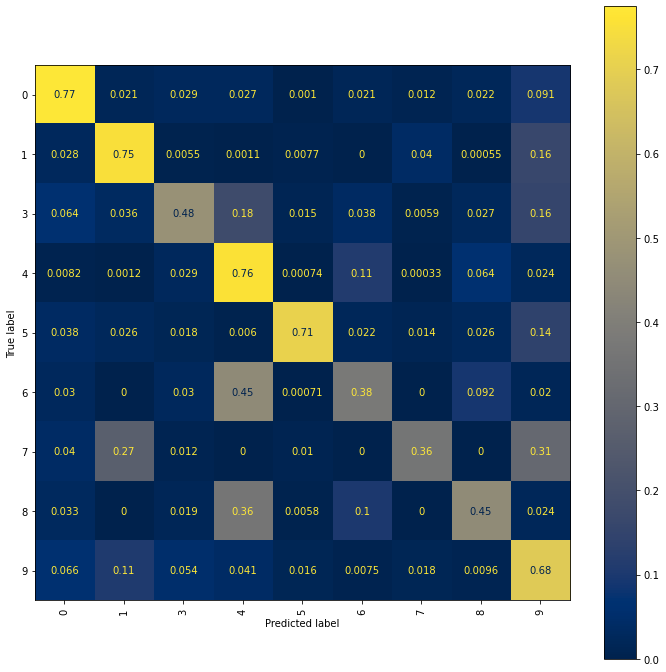

In [7]:
from sklearn.metrics import plot_confusion_matrix

# In this case I'm going to set normalize to true, since I'm mostly interested
# in relative accuracy of the classes
matrix=plot_confusion_matrix(clfs["dt_unbounded"], 
                             df_validation[features],
                             df_validation["pitch_type2"], 
                             xticks_rotation='vertical', 
                             cmap='cividis', 
                             normalize='true')
matrix.figure_.set_size_inches(12,12)

Ok, we see a decently strong diagonal line, with a few classes below 50% accuracy on a nine class scale. One place that looks a lot like our boxing data is class 6, which we tend to predict more as class four than class six. How much does this matter? Well, it depends on your use case for the model - if you go back and look at our list of pitches you'll see that class four is a four seam fastball and class six is a two seam fastball. So the pitches are different but not nearly as different as, say, any fastball and change ups.

Another good one to consider here is is pitch 7, which should be a knuckle curve ball, which we only correctly predict about a third of the time. We regularly misclassify this as either a change up or a slider. Both change ups and sliders join knuckle curve balls as off speed balls, moving slower than fastballs, and it's clear the model we've built is picking up on this. 